In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import math

In [2]:
def calculate_FTTSE(energy, time, is_training=True):
    if is_training:
        return energy * (time**2)
    else:
        return energy * math.exp(time)
    
def calculate_G_score(alpha, beta, f1, energy):
    return alpha * f1 + beta * energy

In [3]:
df = pd.read_csv("data/presentation.csv")
averages_df = df.groupby("Model").mean().reset_index()

averages_df['FTTSE_Training'] = averages_df.apply(
    lambda row: calculate_FTTSE(row['Training_Energy_Joules'], row['Training_Time_Seconds'], is_training=True), axis=1)

averages_df['FTTSE_Inference'] = averages_df.apply(
    lambda row: calculate_FTTSE(row['Inference_Energy_Joules'], row['Inference_Time_Seconds'], is_training=False), axis=1)

print(averages_df)

                 Model  Trial  Training_Time_Seconds  Training_Energy_Joules  \
0        Decision Tree    2.0             261.736667             4187.786667   
1  Logistic Regression    2.0              24.193333              726.626667   
2          Naive Bayes    2.0               8.236667              103.690000   

   Inference_Time_Seconds  Inference_Energy_Joules  F1_Score  FTTSE_Training  \
0                0.043333                 0.826667    0.5573    2.868889e+08   
1                0.110000                 3.003333    0.6081    4.253072e+05   
2                1.253333                18.203333    0.5760    7.034607e+03   

   FTTSE_Inference  
0         0.863276  
1         3.352555  
2        63.748016  


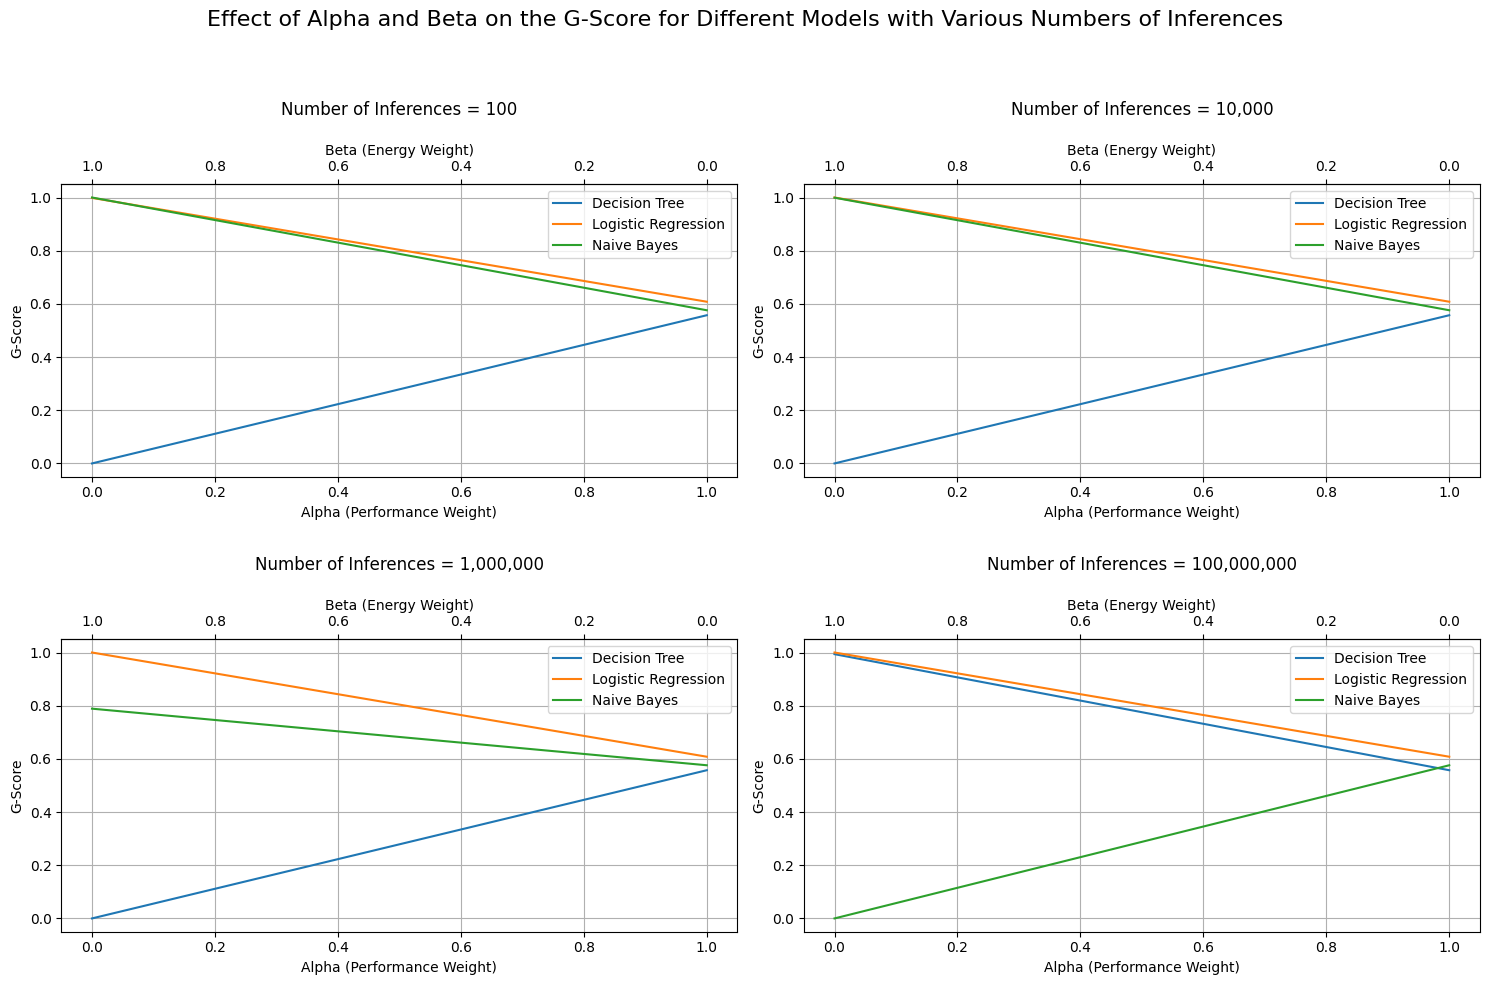

In [23]:
nr_inferences = [1e2, 1e4, 1e6, 1e8]
alpha_values = np.linspace(0, 1, 1000)

# Create a 2x2 grid of subplots
fig, axs = plt.subplots(2, 2, figsize=(15, 10))
axs = axs.flatten()

for idx, inf in enumerate(nr_inferences):
    ax = axs[idx]

    # Calculate combined and normalized FTTSE values for current inference number
    averages_df['FTTSE_combined'] = (1 - averages_df['FTTSE_Training']) + (1 - averages_df['FTTSE_Inference']) * inf
    fttse_min, fttse_max = averages_df['FTTSE_combined'].min(), averages_df['FTTSE_combined'].max()
    averages_df['FTTSE_norm'] = (averages_df['FTTSE_combined'] - fttse_min) / (fttse_max - fttse_min)

    for model in averages_df["Model"]:
        f1 = averages_df[averages_df["Model"] == model]["F1_Score"].values[0]
        energy = averages_df[averages_df["Model"] == model]["FTTSE_norm"].values[0]

        G_scores = []
        for alpha in alpha_values:
            beta = 1 - alpha
            G_scores.append(calculate_G_score(alpha, beta, f1, energy))

        # Plot the effect of alpha on G-score
        ax.plot(alpha_values, G_scores, label=model)

    # Add labels, title, and legend
    ax.set_xlabel("Alpha (Performance Weight)")
    ax.set_ylabel("G-Score")
    ax.set_title(f'\nNumber of Inferences = {inf:,.0f}\n')
    ax.grid(True)
    ax.legend()

    # Add a secondary x-axis at the top for Beta (1 - Alpha)
    secax = ax.secondary_xaxis('top')
    secax.set_xticks(np.linspace(0, 1, 6))  # Adjust tick positions as needed
    secax.set_xticklabels([f"{1 - val:.1f}" for val in np.linspace(0, 1, 6)])
    secax.set_xlabel("Beta (Energy Weight)")

# Set the title for the entire figure
fig.suptitle('Effect of Alpha and Beta on the G-Score for Different Models with Various Numbers of Inferences', fontsize=16)
plt.tight_layout(rect=[0, 0, 1, 0.96])  # Adjust layout to make room for the suptitle
plt.show()